In [1]:
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from scipy.optimize import curve_fit

import src.io as sio
import src.preprocessing as spp
import src.fitting as sft

In [2]:
AFM_FOLDER = "20200818_Akiyama_AFM/"
AFM_FOLDER1 = "20200721_Akiyama_AFM/"
AFM_FOLDER2 = "20200824_Akiyama_AFM/"
AFM_FOLDER3 = "20200826_TFSC_Preamp_AFM/11613_Tip_5/Akiyama_Tip_Stage/"
AFM_FOLDER4 = "20200826_TFSC_Preamp_AFM/11613_Tip_5/Custom_Tip_Stage/"
AFM_FOLDER5 = "20200828_Tip_Approach1/"

## 20200721_Akiyama_AFM

In [ ]:
params, data = sio.read_dat(AFM_FOLDER1 + "frq-sweep002.dat")
freq_shift = data["Frequency Shift (Hz)"].values
amplitude = data["Amplitude (m)"].values
phase = data["Phase (deg)"].values
amp_freq_sweep = sft.fit_lorentzian(freq_shift, amplitude, linear_offset=True)
phase_freq_sweep = sft.fit_fano(freq_shift, phase)

In [ ]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(freq_shift, amplitude)
ax1.plot(freq_shift, amp_freq_sweep.best_fit)
ax1.set_ylabel(data.columns[2])

ax2.plot(freq_shift, phase)
ax2.plot(freq_shift, phase_freq_sweep.best_fit)
ax2.set_ylabel(data.columns[3])
ax2.set_xlabel(data.columns[0])

Quality factor can be calculated as $ Q = \frac{f_R}{\Delta f} $

In [ ]:
print(f'Q-factor= {params["f_res (Hz)"] / amp_freq_sweep.params["fwhm"].value}')

## 20200818_Akiyama_AFM

In [ ]:
params, data = sio.read_dat(AFM_FOLDER + "frq-sweep001.dat")
#pprint(params, sort_dicts=False)
freq_shift = data["Frequency Shift (Hz)"]
amplitude = data["Amplitude (m)"]
phase = data["Phase (deg)"]
fano = sft.fit_fano(freq_shift, amplitude)
lorentzian = sft.fit_fano(freq_shift, phase)
params

## Equations for calculating Q factor

$$ Q = \frac{f_R}{\Delta f} $$

$$ Q = \frac{A(\omega_0)}{A_{in}} $$

In [ ]:
f_res = 44379.7064
sigma = 62.2841355
print(f_res/sigma)

A_drive = 50e-3
A_res = 28.3e-6 * 1 / 500e-6
print(A_res/A_drive)

# Calibration
A_drive = 50e-3
osc_amp = 50e-9

print(osc_amp/A_drive)

## Plot frequency sweep curves

In [ ]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(freq_shift, amplitude)
ax1.plot(freq_shift, fano.best_fit)
ax1.set_ylabel(data.columns[2])

ax2.plot(freq_shift, phase)
ax2.plot(freq_shift, lorentzian.best_fit)
ax2.set_ylabel(data.columns[3])
ax2.set_xlabel(data.columns[1])

## Extract fit values

In [ ]:
print("{} = {:.1f} +- {:.1f}".format(fano.params["sigma"].name, fano.params["sigma"].value, fano.params["sigma"].stderr))
print("{} = {:.2e} +- {:.0e}".format(fano.params["amplitude"].name, fano.params["amplitude"].value, fano.params["amplitude"].stderr))

# 20200824_Akiyama_AFM

## Automatically read files from disk

Reads all files stored in **AFM_FOLDER2 = "20200824_Akiyama_AFM/"** and plots the amplitude and phase data.

Optionally, the data can be fit to Fano resonances by setting the variable
```python
fit = True
```
The Q-factor is calculated as:

$$ Q = \frac{f_R}{\Delta f} = \frac{f_R}{2 \sigma} $$

Errors are calculated as (this also gives an estimate of the SNR):
$$ \frac{\Delta Q}{Q} = \sqrt{ \left( \frac{\Delta (\Delta f)}{\Delta f} \right)^2 + \left( \frac{\Delta (\sigma)}{\sigma} \right)^2 } $$

Another estimate of the SNR, is the Chi square or weighted sum of squared deviations (lower is better):
$$ \chi^2 = \sum_{i} {\frac{(O_i - C_i)^2}{\sigma_i^2}} $$

In [ ]:
%matplotlib widget

fit = True    # Setting to True will take slightly longer due to the fitting protocols

files = []
for file in os.listdir("../../Data/" + AFM_FOLDER2):
    if file.endswith(".dat"):
        files.append(file) 

fig, ax = plt.subplots(nrows=len(files), ncols=2)

for idx, file in enumerate(files):
    params, data = sio.read_dat(AFM_FOLDER2 + file)
    freq_shift = data["Frequency Shift (Hz)"]
    amplitude = data["Amplitude (m)"]
    phase = data["Phase (deg)"]

    ax[idx, 0].plot(freq_shift, amplitude)
    ax[idx, 0].set_ylabel(data.columns[2])
    ax[idx, 0].set_title(file)

    ax[idx, 1].plot(freq_shift, phase)
    ax[idx, 1].set_ylabel(data.columns[3])
    ax[idx, 1].set_title(file)
    
    if fit:
        fano1 = sft.fit_fano(freq_shift, amplitude)
        q_factor = (params["Center Frequency (Hz)"] + fano1.params["center"].value) / (2 * fano1.params["sigma"].value)
        q_factor_err = q_factor * np.sqrt((fano1.params["center"].stderr/fano1.params["center"].value)**2 + (fano1.params["sigma"].stderr/fano1.params["sigma"].value)**2)
        ax[idx, 0].plot(freq_shift, fano1.best_fit, label="Q={:.0f}$\pm{:.0f}$".format(q_factor, q_factor_err))
        ax[idx, 0].legend()
        fano2 = sft.fit_fano(freq_shift, phase, linear_offset=True)
        ax[idx, 1].plot(freq_shift, fano2.best_fit)
        print("chi-square ({}) = {:.2e}".format(file, fano1.chisqr))

fig.tight_layout()
fig.text(0.5, 0.02, data.columns[1], ha='center', va='center')

## 20200826_TFSC_Preamp_AFM 
### 11613_Tip_5

In [ ]:
%matplotlib widget

fit = True    # Setting to True will take slightly longer due to the fitting protocols

files = []
for file in os.listdir("../../Data/" + AFM_FOLDER4):
    if file.endswith(".dat"):
        files.append(file) 

fig, ax = plt.subplots(nrows=len(files), ncols=2)

for idx, file in enumerate(files):
    params, data = sio.read_dat(AFM_FOLDER4 + file)
    freq_shift = data["Frequency Shift (Hz)"]
    amplitude = data["Amplitude (m)"]
    phase = data["Phase (deg)"]

    ax[idx, 0].plot(freq_shift, amplitude)
    ax[idx, 0].set_ylabel(data.columns[2])
    ax[idx, 0].set_title(file)

    ax[idx, 1].plot(freq_shift, phase)
    ax[idx, 1].set_ylabel(data.columns[3])
    ax[idx, 1].set_title(file)
    
    if fit:
        fano1 = sft.fit_fano(freq_shift, amplitude)
        q_factor = (params["Center Frequency (Hz)"] + fano1.params["center"].value) / (fano1.params["sigma"].value)
        q_factor_err = q_factor * np.sqrt((fano1.params["center"].stderr/fano1.params["center"].value)**2 + (fano1.params["sigma"].stderr/fano1.params["sigma"].value)**2)
        ax[idx, 0].plot(freq_shift, fano1.best_fit, label="Q={:.0f}$\pm{:.0f}$".format(q_factor, q_factor_err))
        ax[idx, 0].legend()
        fano2 = sft.fit_fano(freq_shift, phase, linear_offset=True)
        ax[idx, 1].plot(freq_shift, fano2.best_fit)
        print("chi-square ({}) = {:.2e}".format(file, fano1.chisqr))

fig.tight_layout()
fig.text(0.5, 0.02, data.columns[1], ha='center', va='center')

In [ ]:
omega_0 = 1
omega = np.linspace(0, 2, 1000)
Q = 1

ratio = omega / omega_0

phi = np.arctan(-ratio / (Q * (1 - ratio**2)))

fid, ax = plt.subplots()
ax.plot(ratio, phi)

# Calibration from Thermal Noise density

From Atomic Force Microscopy, Second Edition by Bert Voigtländer

Section 11.6.5 Experimental Determination of the Sensitivity and Spring Constant in AFM Without Tip-Sample Contact

Eq. 11.28 and 11.26

In [ ]:
%matplotlib widget
file = "SignalAnalyzer_Spectrum001"
params, data = sio.read_dat(AFM_FOLDER4 + file)

calibration_params = sft.find_afm_calibration_parameters(data, frequency_range=[40000, 48000], Q=1000, f_0_guess=44000)
fig, ax = plt.subplots()
ax.plot(calibration_params["Frequency (Hz)"], calibration_params["PSD squared (V**2/Hz)"])
ax.plot(calibration_params["Frequency (Hz)"], calibration_params["PSD squared fit (V**2/Hz)"])
print("Calibration (m/V) =", calibration_params["Calibration (m/V)"])

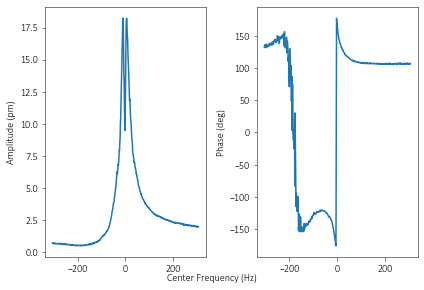

In [43]:
%matplotlib inline

fit = False    # Setting to True will take slightly longer due to the fitting protocols

files = []
for file in os.listdir("../../Data/" + AFM_FOLDER5):
    if file.endswith(".dat"):
        files.append(file) 


files = ["Gold_leaf_approach/frq-sweep003.dat"]
        
fig, ax = plt.subplots(nrows=len(files), ncols=2)

for idx, file in enumerate(files):
    params, data = sio.read_dat(AFM_FOLDER5 + file)
    freq_shift = data["Frequency Shift (Hz)"]
    amplitude = data["Amplitude (m)"]
    phase = data["Phase (deg)"]
    
    if len(files) == 1:
        ax[0].plot(freq_shift, amplitude*1e12)
        ax[0].set_ylabel("Amplitude (pm)")

        ax[1].plot(freq_shift, phase)
        ax[1].set_ylabel(data.columns[3])
    else:
        ax[idx, 0].plot(freq_shift, amplitude)
        ax[idx, 0].set_ylabel(data.columns[2])
        ax[idx, 0].set_title(file)

        ax[idx, 1].plot(freq_shift, phase)
        ax[idx, 1].set_ylabel(data.columns[3])
        ax[idx, 1].set_title(file)

        if fit:
            fano1 = sft.fit_fano(freq_shift, amplitude)
            #q_factor = (params["Center Frequency (Hz)"] + fano1.params["center"].value) / (fano1.params["sigma"].value)
            #q_factor_err = q_factor * np.sqrt((fano1.params["center"].stderr/fano1.params["center"].value)**2 + (fano1.params["sigma"].stderr/fano1.params["sigma"].value)**2)
            ax[idx, 0].plot(freq_shift, fano1.best_fit)
            ax[idx, 0].legend()
            fano2 = sft.fit_fano(freq_shift, phase, linear_offset=True)
            ax[idx, 1].plot(freq_shift, fano2.best_fit)
            print("chi-square ({}) = {:.2e}".format(file, fano1.chisqr))

fig.tight_layout()
fig.text(0.5, 0.02, data.columns[1], ha='center', va='center')